In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import json
import jsonlines

In [2]:
def load_limited_jsonl(file_path, num_lines=1000):
    data = []
    with jsonlines.open(file_path) as reader:
        for i, obj in enumerate(reader):
            if i >= num_lines:
                break
            data.append(obj)
    return data

file_path = 'v1.0-simplified_nq-dev-all.jsonl'
limited_data = load_limited_jsonl(file_path, num_lines=1000)

print(f"Number of records loaded: {len(limited_data)}")
print("First record:")
print(json.dumps(limited_data[0], indent=2))

Number of records loaded: 1000
First record:
{
  "annotations": [
    {
      "annotation_id": 13591449469826568799,
      "long_answer": {
        "candidate_index": 92,
        "end_byte": 67824,
        "end_token": 925,
        "start_byte": 66429,
        "start_token": 808
      },
      "short_answers": [
        {
          "end_byte": 66817,
          "end_token": 837,
          "start_byte": 66588,
          "start_token": 816
        }
      ],
      "yes_no_answer": "NONE"
    },
    {
      "annotation_id": 6237931520544082939,
      "long_answer": {
        "candidate_index": 92,
        "end_byte": 67824,
        "end_token": 925,
        "start_byte": 66429,
        "start_token": 808
      },
      "short_answers": [
        {
          "end_byte": 66609,
          "end_token": 819,
          "start_byte": 66588,
          "start_token": 816
        }
      ],
      "yes_no_answer": "NONE"
    },
    {
      "annotation_id": 12127791536449879527,
      "long_answer": {

In [3]:
def classify_question(record):
    """
    Classify questions as extractive or abstractive based on the presence of long/short answers.
    """
    annotations = record.get("annotations", [])
    
    has_long_answer = any(
        ann["long_answer"]["start_byte"] != -1 and ann["long_answer"]["end_byte"] != -1
        for ann in annotations
    )
    
    has_short_answers = any(
        len(ann.get("short_answers", [])) > 0
        for ann in annotations
    )
    
    if has_long_answer or has_short_answers:
        return "Extractive"
    else:
        return "Abstractive"

def create_classified_dataset(file_path, num_lines=2000):
    classified_data = []
    
    with jsonlines.open(file_path) as reader:
        for i, record in enumerate(reader):
            if i >= num_lines:
                break
            
            question_text = record.get("question_text", "")
            question_tokens = record.get("question_tokens", [])
            classification = classify_question(record)
            
            classified_data.append({
                "question_text": question_text,
                "question_tokens": question_tokens,
                "classification": classification
            })
    
    df = pd.DataFrame(classified_data)
    return df

# Create the dataset with the first 1000 records
classified_dataset = create_classified_dataset(file_path, num_lines=2000)

# Save or display the dataset
classified_dataset.to_csv('classified_questions.csv', index=False)
print("Sample of the classified dataset:")
classified_dataset.head()

Sample of the classified dataset:


,question_text,question_tokens,classification
0,what do the 3 dots mean in math,"[what, do, the, 3, dots, mean, in, math]",Extractive
1,when was the writ watch invented by who,"[when, was, the, writ, watch, invented, by, who]",Abstractive
2,who wrote the song photograph by ringo starr,"[who, wrote, the, song, photograph, by, ringo,...",Extractive
3,who is playing the halftime show at super bowl...,"[who, is, playing, the, halftime, show, at, su...",Extractive
4,star wars the clone wars anakin voice actor,"[star, wars, the, clone, wars, anakin, voice, ...",Extractive


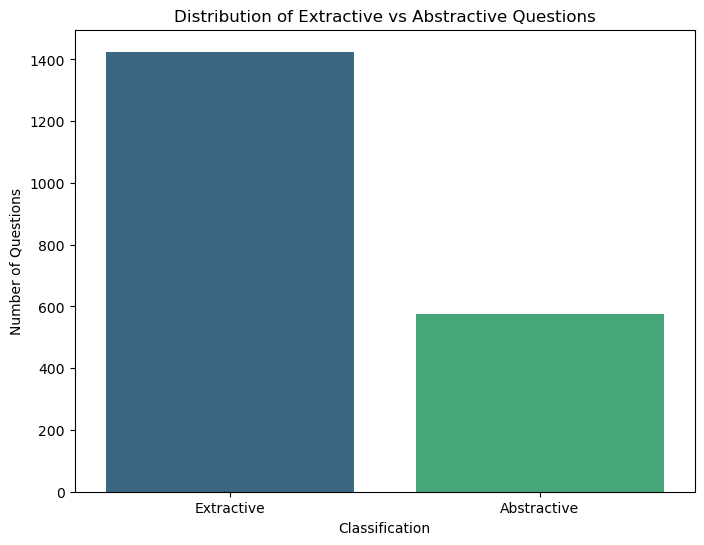

Class Distribution:
classification
Extractive     1425
Abstractive     575
Name: count, dtype: int64


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(df, class_column='classification'):
    """
    Plot the distribution of extractive and abstractive questions.
    """
    class_counts = df[class_column].value_counts()
    
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.title('Distribution of Extractive vs Abstractive Questions')
    plt.xlabel('Classification')
    plt.ylabel('Number of Questions')
    plt.show()
    
    print(f"Class Distribution:\n{class_counts}")

plot_class_distribution(classified_dataset)

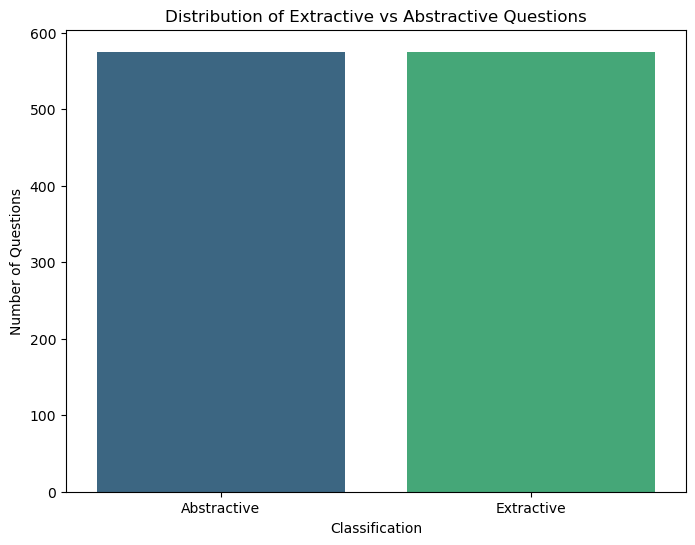

Class Distribution:
classification
Abstractive    575
Extractive     575
Name: count, dtype: int64


In [5]:
from sklearn.utils import resample

def undersample_class(df, class_column='classification', target_class='Abstractive'):
    """
    Undersample the majority class to balance the dataset.
    """
    # Separate majority and minority classes
    df_majority = df[df[class_column] != target_class]
    df_minority = df[df[class_column] == target_class]

    # Undersample majority class
    df_majority_undersampled = resample(df_majority, 
                                        replace=False,     # sample without replacement
                                        n_samples=len(df_minority),  # match number of minority class
                                        random_state=42)   # reproducible results

    # Combine minority class with undersampled majority class
    df_balanced = pd.concat([df_minority, df_majority_undersampled])
    return df_balanced

# Perform undersampling
balanced_dataset = undersample_class(classified_dataset)
plot_class_distribution(balanced_dataset)


In [6]:
classified_dataset.head()

,question_text,question_tokens,classification
0,what do the 3 dots mean in math,"[what, do, the, 3, dots, mean, in, math]",Extractive
1,when was the writ watch invented by who,"[when, was, the, writ, watch, invented, by, who]",Abstractive
2,who wrote the song photograph by ringo starr,"[who, wrote, the, song, photograph, by, ringo,...",Extractive
3,who is playing the halftime show at super bowl...,"[who, is, playing, the, halftime, show, at, su...",Extractive
4,star wars the clone wars anakin voice actor,"[star, wars, the, clone, wars, anakin, voice, ...",Extractive


In [7]:
import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def extract_features(df):
    """
    Extract features from the question text to differentiate extractive and abstractive questions.
    """
    df['question_length'] = df['question_text'].apply(lambda x: len(word_tokenize(x)))
    
    common_keywords = ['what', 'how', 'when', 'who', 'where', 'why']
    for word in common_keywords:
        df[f'contains_{word}'] = df['question_text'].apply(lambda x: int(word in x.lower()))
    \
    df['pos_tags'] = df['question_text'].apply(lambda x: [tag for word, tag in pos_tag(word_tokenize(x))])
    
    # Named Entity Recognition (NER) can be added later if needed
    return df

# Apply feature extraction on your classified dataset
df = extract_features(balanced_dataset)

print("Features extracted:")
df.head()


[nltk_data] Downloading package punkt to /Users/anshankul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/anshankul/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Features extracted:


,question_text,question_tokens,classification,question_length,contains_what,contains_how,contains_when,contains_who,contains_where,contains_why,pos_tags
1,when was the writ watch invented by who,"[when, was, the, writ, watch, invented, by, who]",Abstractive,8,0,0,1,1,0,0,"[WRB, VBD, DT, NN, NN, VBN, IN, WP]"
5,meaning behind the song whiter shade of pale,"[meaning, behind, the, song, whiter, shade, of...",Abstractive,8,0,0,0,0,0,0,"[VBG, IN, DT, NN, NN, NN, IN, NN]"
8,when do new chapters of owari no seraph come out,"[when, do, new, chapters, of, owari, no, serap...",Abstractive,10,0,0,1,0,0,0,"[WRB, VBP, JJ, NNS, IN, JJ, DT, NN, VB, RP]"
9,where does the last name painter come from,"[where, does, the, last, name, painter, come, ...",Abstractive,8,0,0,0,0,1,0,"[WRB, VBZ, DT, JJ, NN, VBD, VBN, IN]"
12,what are the challenges faced by the cotton te...,"[what, are, the, challenges, faced, by, the, c...",Abstractive,12,1,0,0,0,0,0,"[WDT, VBP, DT, NNS, VBN, IN, DT, NN, NN, NN, I..."


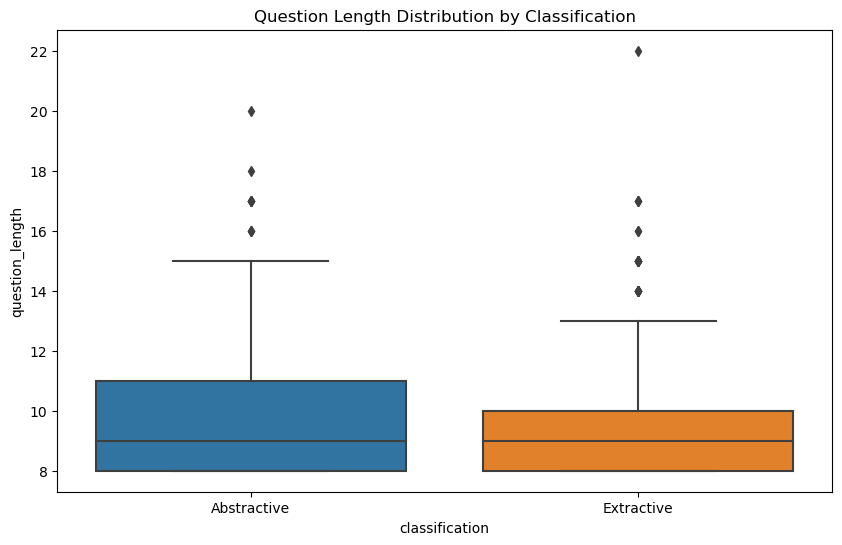

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot question length distribution by class
plt.figure(figsize=(10, 6))
sns.boxplot(x='classification', y='question_length', data=df)
plt.title('Question Length Distribution by Classification')
plt.show()

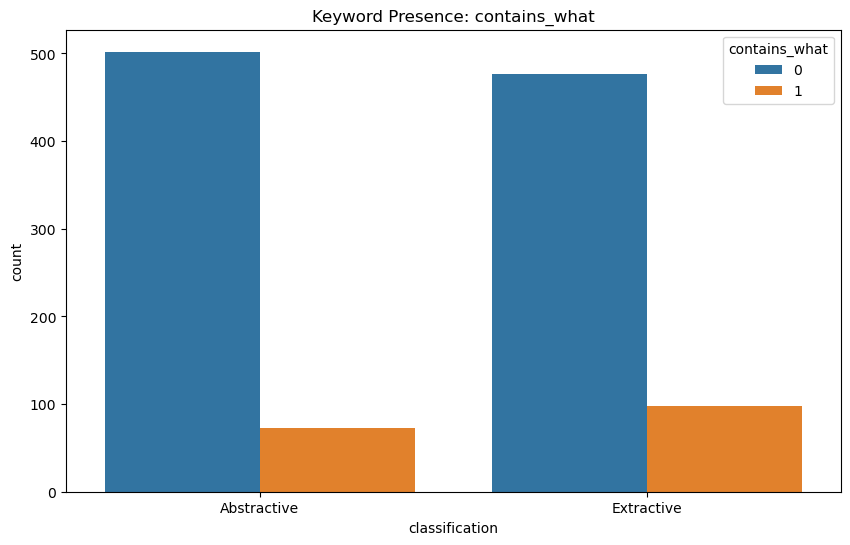

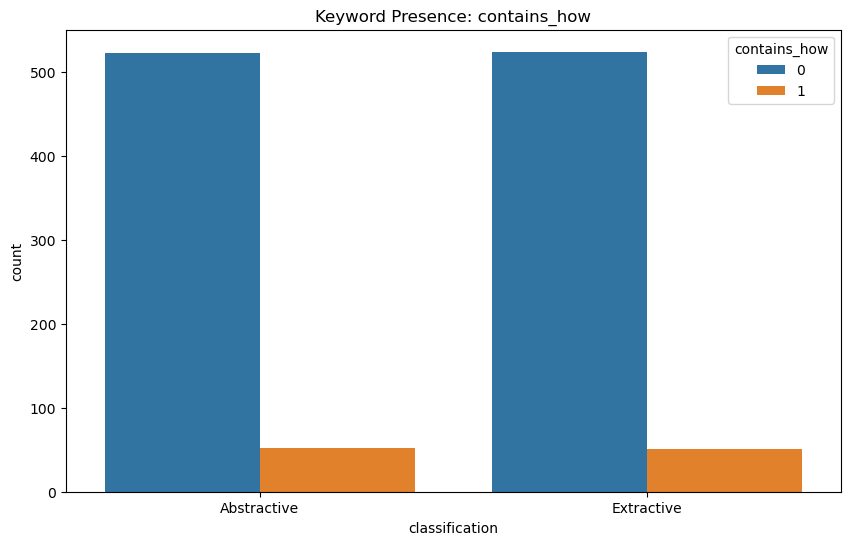

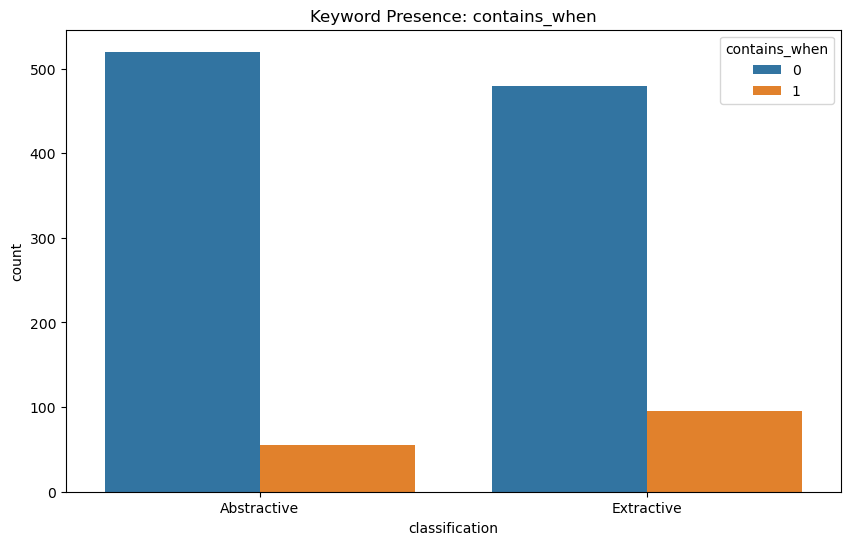

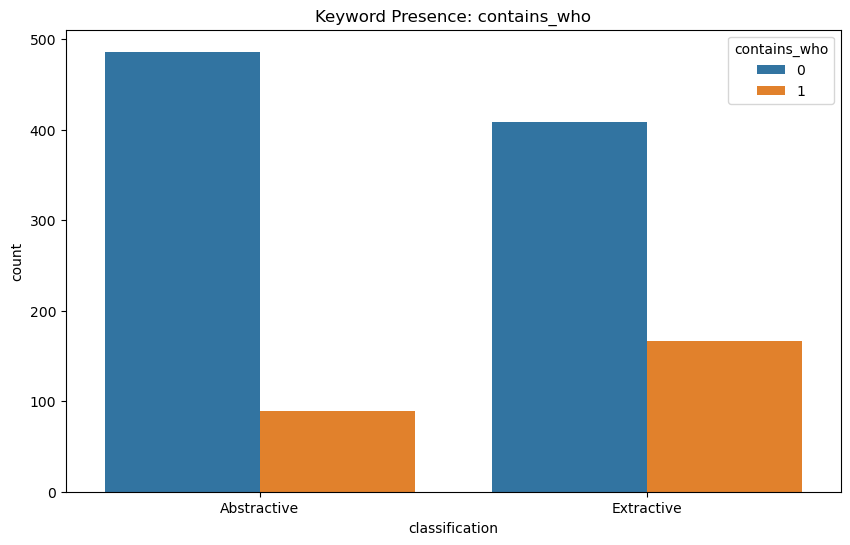

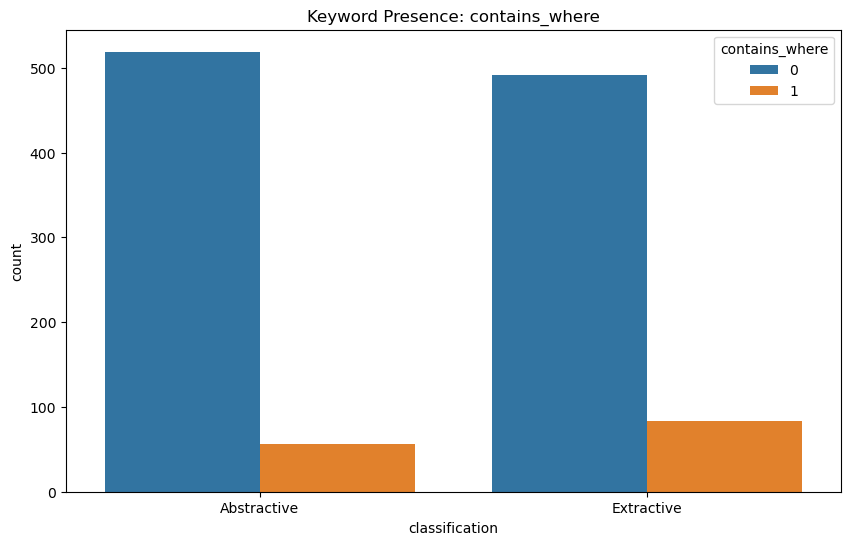

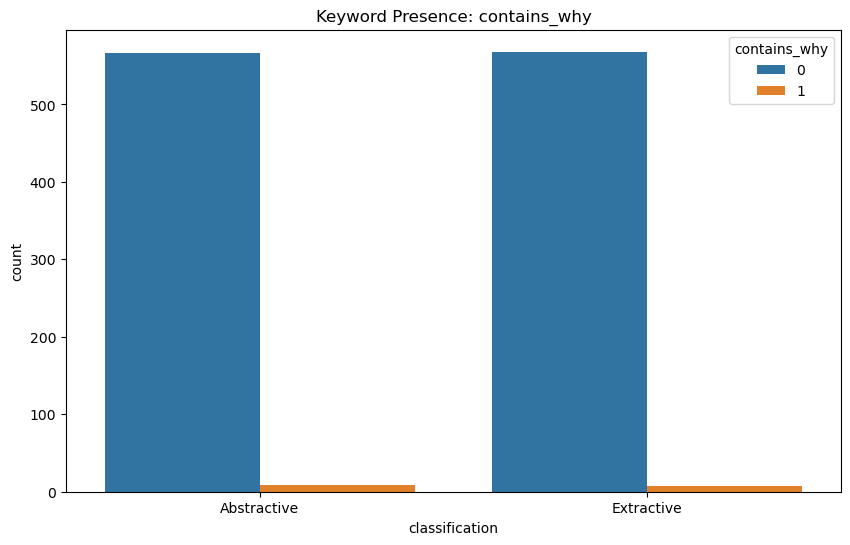

In [9]:
# Plot keyword presence by class
keyword_columns = [col for col in df.columns if 'contains_' in col]
for keyword in keyword_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='classification', hue=keyword, data=df)
    plt.title(f'Keyword Presence: {keyword}')
    plt.show()

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['question_text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [20]:
tfidf_df.head(10)

,10,11,12,13,2000,2002,2007,2011,2015,2016,...,write,written,wrote,xbox,year,years,yo,york,young,zones
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.634629,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


              precision    recall  f1-score   support

           0       0.67      0.53      0.59       179
           1       0.59      0.72      0.65       166

    accuracy                           0.62       345
   macro avg       0.63      0.63      0.62       345
weighted avg       0.63      0.62      0.62       345



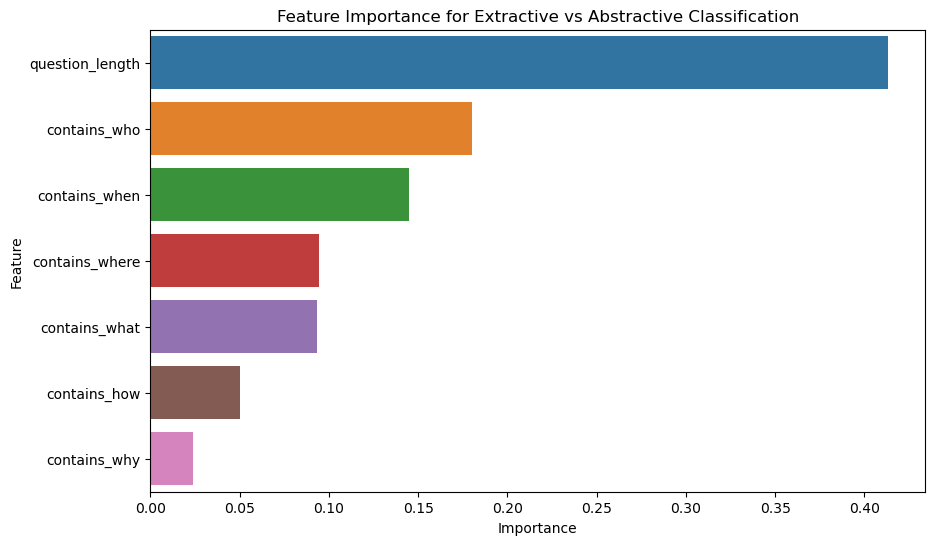

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df[['question_length'] + keyword_columns]
y = df['classification'].apply(lambda x: 1 if x == 'Extractive' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df.sort

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for Extractive vs Abstractive Classification')
plt.show()


In [12]:
classified_dataset.shape

(2000, 3)

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

y_pred_rf = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))


Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.69      0.53      0.60       179
           1       0.59      0.74      0.66       166

    accuracy                           0.63       345
   macro avg       0.64      0.64      0.63       345
weighted avg       0.64      0.63      0.63       345



In [23]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

y_pred_xgb = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred_xgb))


Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       179
           1       0.59      0.73      0.65       166

    accuracy                           0.63       345
   macro avg       0.63      0.63      0.62       345
weighted avg       0.64      0.63      0.62       345



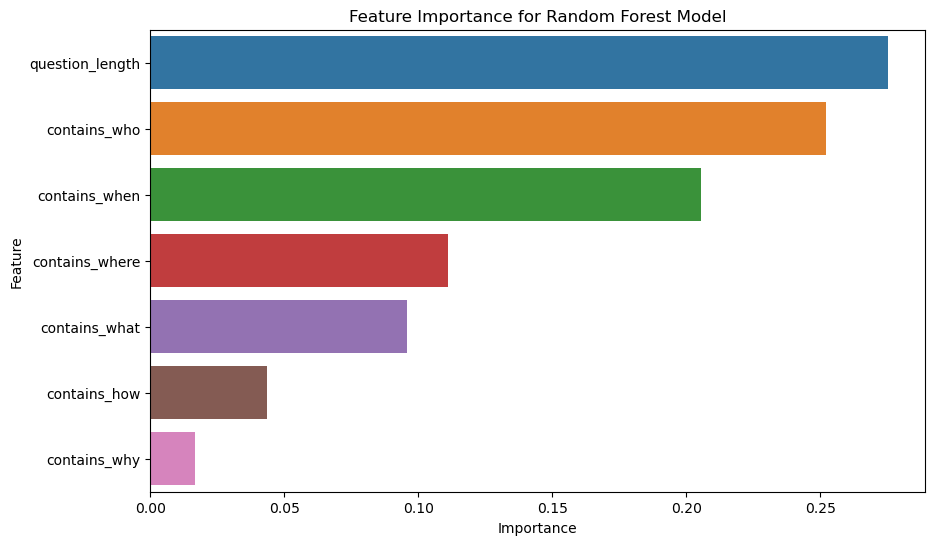

NameError: name 'best_xgb' is not defined

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

rf_importances = best_rf.feature_importances_
rf_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_importances})
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance_df)
plt.title('Feature Importance for Random Forest Model')
plt.show()

xgb_importances = best_xgb.feature_importances_
xgb_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_importances})
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_feature_importance_df)
plt.title('Feature Importance for XGBoost Model')
plt.show()
